# **Lab 1 - Explainable and Trustworthy AI**


---



**Teaching Assistant**: Eleonora Poeta (eleonora.poeta@polito.it)

**Lab 1:** Interpretable by design models on structured data

# **Decision Trees**


---



* Decision trees offer an approach to achieve interpretability-by-design of machine learning models.  They give a transparent and intuitive representation of the decision-making process followed by the model. This transparency allows domain experts to easily understand and validate the model's predictions.

When assessing the interpretability of decision trees, several key aspects should be considered depending if assessing *global* or *local* interpretability.
In particular, you have to analyze:



1.   When assessing **global** interpretability you have to *inspect the entire decision tree*. Then, as mesures for the global interpretability there are:


> * **Depth** of the tree → Shallow trees with fewer levels are easier to interpret, as they represent simpler decision rules. In contrast, deeper trees may become overly complex and difficult to interpret, potentially sacrificing transparency for improved accuracy.
* **Size** of the tree → This includes the *number of nodes* and the *number of splits*. A larger tree with more nodes and splits may capture intricate patterns in the data but could also lead to overfitting and decreased interpretability.




2.  When assessing **local** interpretability you have to *inspect the individual path of a single prediction.* Then, as mesures for the local interpretability there is:


> * **Lenght** of the individual path.




---

## **Exercise 1**
The *Diabetes prediction dataset* comprises medical and demographic data, alongside diabetes status (positive:1/negative:0) of patients. It includes features like age, gender, body mass index (BMI), hypertension, heart disease, smoking history, HbA1c level, and blood glucose level.
In the following exercise you have to:

* Fit a [**Decision tree classifier**](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) model on **Diabetes dataset** and evaluate it calculating model's accuracy.


> *   Visualize the decision tree obtained. Are you able to interpret the decision process?
*   Try again with `max_depth=4` and compare the two trees. Which one is the most interpretable?




* Analyze **Global Interpretability**:


> * Continue visualizing the obtained decision tree with `max_depth=4`. Which attributes are the most discriminating? Plot the feature importances and then analyze the values.
* Calculate the size of the decision tree in terms of the number of nodes, subdivisions, and depth. How these metrics affect the interpretability of the decision tree globally?


* Analyze **Local Interpretability**:


> * Consider the instances 100, 150 and 200 of the train dataset.
* What are the individual paths? What are the instances allocated in the paths?
* For each of the previous instances, calculate the length of each path from the root node to the leaf node to which the instance belongs. How the length of these paths contributes to the interpretability of the decision tree locally?


***Hint*** :

> * Before starting do some **preprocessing** of the Diabetes dataset as previously seen in Lab 0.1 (Address null values and preprocess categorical attributes.)
* As **split ratio** for the dataset use the standard one: train (80%) and test (20%). Account for any class imbalance during the train-test split by making use of the **stratify** argument



## **Solution:**

In [1]:
# If your dataset is stored on Google Drive, mount the drive before reading it
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn import tree
import pandas as pd

### Data Preprocessing

In [9]:
# Declaring variables
age_category = ['Child (0-14]', 'Young (14-24]', 'Adults (24-50]', 'Senior (50+]']
smoking_history_cat = ['never', 'not current', 'No Info', 'current', 'ever']

#Importing csv file
df = pd.read_csv('./diabetes.csv')

#Finding null-values and duplicates
print(f'Null vals: ', df.isna().sum()) #It seems we have no null values, so no null values transformation
print(f"Number of duplicate rows: {df.duplicated(keep=False).sum()}") #Some duplicates are present, shall I remove them?

df.drop_duplicates(inplace=True)  # Chose to remove them
print(f"Number of duplicate rows after removing duplicates: {df.duplicated(keep=False).sum()}")

Null vals:  gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64
Number of duplicate rows: 6939
Number of duplicate rows after removing duplicates: 0


In [10]:
#Splitting dataset
df_train, df_test = train_test_split(df, test_size = 0.2, train_size = 0.8, shuffle = True, random_state=42, stratify = df['diabetes'])

In [11]:
#Combining 'former' in 'smoking history' feature
df_train.loc[df_train['smoking_history'] == 'former', 'smoking_history'] = 'not current'
df_test.loc[df_test['smoking_history'] == 'former', 'smoking_history'] = 'not current'

#Discretizing age
df_train['age_disc']=pd.cut(x=df['age'], bins=[0,14,24,50,100],labels=age_category)
df_train = df_train.drop(columns=['age']) # Remove the old age column
df_test['age_disc']=pd.cut(x=df['age'], bins=[0,14,24,50,100],labels=age_category)
df_test = df_test.drop(columns=['age']) # Remove the old age column

In [12]:
# Create a copy of each DataFrame
df_train_encoded = df_train.copy()
df_test_encoded = df_test.copy()

In [13]:
# Encoding age and smoking history for train and test dataframes
ord_enc = OrdinalEncoder(categories=[smoking_history_cat, age_category])
ord_enc.fit(df_train_encoded[['smoking_history', 'age_disc']])
df_train_encoded[['smoking_history', 'age_disc_enc']] = ord_enc.transform(df_train_encoded.loc[:, ['smoking_history', 'age_disc']])
df_test_encoded[['smoking_history', 'age_disc_enc']] = ord_enc.transform(df_test_encoded.loc[:, ['smoking_history', 'age_disc']])
#Removing old columns
df_train_encoded.drop(columns=["age_disc"], axis=1, inplace=True)
df_test_encoded.drop(columns=["age_disc"], axis=1, inplace=True)

In [14]:
#Checking gender values
# Removing gender 'Other' rows
df_train_encoded = df_train_encoded[df_train_encoded.gender != 'Other']
df_test_encoded = df_test_encoded[df_test_encoded.gender != 'Other']

#Transforming gender
#Training encoder
ohe = OneHotEncoder(handle_unknown = 'ignore')
ohe.fit(df_train_encoded[['gender']])

#Transforming values
#These give a warning, but it can be ignored
tmp_df_train_gender = pd.DataFrame(ohe.transform(df_train_encoded.loc[:, ['gender']]).toarray(), columns = ohe.get_feature_names_out())
df_train_encoded.drop(columns=['gender'], axis=1, inplace=True)
df_train_encoded = pd.concat([df_train_encoded.reset_index(drop=True), tmp_df_train_gender], axis=1)

tmp_df_test_gender = pd.DataFrame(ohe.transform(df_test_encoded.loc[:, ['gender']]).toarray(), columns = ohe.get_feature_names_out())
df_test_encoded.drop(columns=['gender'], axis=1, inplace=True)
df_test_encoded = pd.concat([df_test_encoded.reset_index(drop=True), tmp_df_test_gender], axis=1)

<ipython-input-14-eb6c7c326cd0>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_encoded.drop(columns=['gender'], axis=1, inplace=True)
<ipython-input-14-eb6c7c326cd0>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_encoded.drop(columns=['gender'], axis=1, inplace=True)


In [15]:
#Normalizing values
features_to_normalize = ['bmi', 'HbA1c_level', 'blood_glucose_level', 'age_disc_enc', 'smoking_history' ]

#Declaring and trainin scaler on TRAIN dataframe
minmax_s = MinMaxScaler()
minmax_s.fit(df_train_encoded[features_to_normalize])

#Transoformning train and test dataframes
df_train_encoded[features_to_normalize] = minmax_s.transform(df_train_encoded[features_to_normalize])
df_test_encoded[features_to_normalize] = minmax_s.transform(df_test_encoded[features_to_normalize])

In [16]:
#Extracting labels
y_train = df_train_encoded.diabetes
x_train = df_train_encoded.drop('diabetes', axis = 1)

y_test = df_test_encoded.diabetes
x_test = df_test_encoded.drop('diabetes', axis = 1)

### Fit the decision tree

Accuracy for decision tree with no constraints:  0.9522001456361178


[Text(0.5011096947748236, 0.9868421052631579, 'x[4] <= 0.582\ngini = 0.161\nsamples = 76902\nvalue = [70116, 6786]'),
 Text(0.5007750398158516, 0.9605263157894737, 'x[5] <= 0.591\ngini = 0.095\nsamples = 73819\nvalue = [70116, 3703]'),
 Text(0.5004403848568795, 0.9342105263157895, 'x[6] <= 0.833\ngini = 0.061\nsamples = 72381\nvalue = [70116, 2265]'),
 Text(0.22315939032133086, 0.9078947368421053, 'x[3] <= 0.341\ngini = 0.021\nsamples = 46401\nvalue = [45901, 500]'),
 Text(0.17952786025001732, 0.881578947368421, 'x[0] <= 0.5\ngini = 0.017\nsamples = 44166\nvalue = [43795, 371]'),
 Text(0.11567005811198391, 0.8552631578947368, 'x[4] <= 0.336\ngini = 0.015\nsamples = 43266\nvalue = [42948, 318]'),
 Text(0.11533540315301183, 0.8289473684210527, 'gini = 0.0\nsamples = 17845\nvalue = [17845, 0]'),
 Text(0.116004713070956, 0.8289473684210527, 'x[3] <= 0.218\ngini = 0.025\nsamples = 25421\nvalue = [25103, 318]'),
 Text(0.07163674013062002, 0.8026315789473685, 'x[1] <= 0.5\ngini = 0.016\nsampl

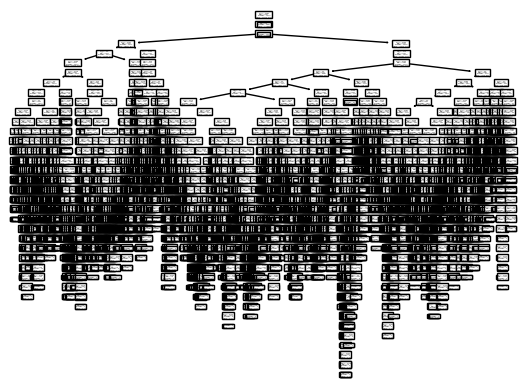

In [17]:
clf = tree.DecisionTreeClassifier()
clf.fit(x_train, y_train)
print(f'Accuracy for decision tree with no constraints: ', clf.score(x_test, y_test))
tree.plot_tree(clf)

###Decision Tree: Max-depth = 4

Accuracy for decision tree with 4 as maximum depth:  0.9716009570373453


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


[Text(0.75, 0.9, 'x[4] <= 0.582\ngini = 0.161\nsamples = 76902\nvalue = [70116, 6786]'),
 Text(0.625, 0.7, 'x[5] <= 0.591\ngini = 0.095\nsamples = 73819\nvalue = [70116, 3703]'),
 Text(0.5, 0.5, 'x[6] <= 0.833\ngini = 0.061\nsamples = 72381\nvalue = [70116, 2265]'),
 Text(0.25, 0.3, 'x[3] <= 0.341\ngini = 0.021\nsamples = 46401\nvalue = [45901, 500]'),
 Text(0.125, 0.1, 'gini = 0.017\nsamples = 44166\nvalue = [43795, 371]'),
 Text(0.375, 0.1, 'gini = 0.109\nsamples = 2235\nvalue = [2106, 129]'),
 Text(0.75, 0.3, 'x[4] <= 0.336\ngini = 0.127\nsamples = 25980\nvalue = [24215, 1765]'),
 Text(0.625, 0.1, 'gini = 0.0\nsamples = 10031\nvalue = [10031, 0]'),
 Text(0.875, 0.1, 'gini = 0.197\nsamples = 15949\nvalue = [14184, 1765]'),
 Text(0.75, 0.5, 'gini = 0.0\nsamples = 1438\nvalue = [0, 1438]'),
 Text(0.875, 0.7, 'gini = 0.0\nsamples = 3083\nvalue = [0, 3083]')]

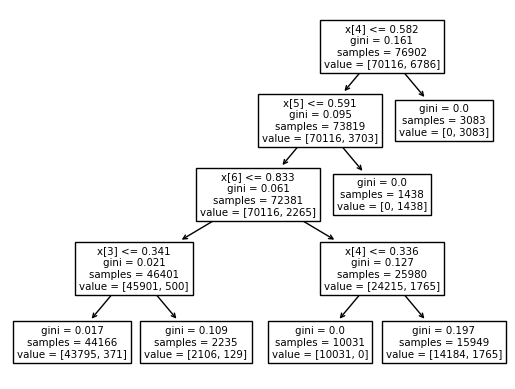

In [35]:
clf = tree.DecisionTreeClassifier(max_depth = 4)
clf.fit(x_train.values, y_train.values)
print(f'Accuracy for decision tree with 4 as maximum depth: ', clf.score(x_test, y_test))
tree.plot_tree(clf)

The decision tree with `max_depth=4` is way more interpretable than the other with no constraints. You could interpret this last cited tree, but is so difficult; we can see it from the fact that you can't even see what's written inside tree nodes.

### Analyze Global Interpretability

In [36]:
#Calculating most discriminant features
features = x_train.columns.tolist()
importances = clf.feature_importances_
feature_importance = list(zip(features, importances))
feature_importance.sort(reverse = True, key = lambda f: f[1])
#print(feature_importance)
print(f'Top 3 most important features: ')
print(feature_importance[0:3])

#Calculating #nodes, #subdivion and depth of the tree
print(f'Number of nodes: {clf.tree_.node_count}')
print(f'Number of subdivisions: {int(clf.tree_.node_count/2)}')
print(f'Tree depth: {clf.get_depth()}')

Top 3 most important features: 
[('HbA1c_level', 0.6650457510459421), ('blood_glucose_level', 0.3205183172380393), ('age_disc_enc', 0.013182497625855268)]
Number of nodes: 11
Number of subdivisions: 5
Tree depth: 4


Higher the nodes lower the interpretation of the model is (global and local). This relations is also valid for depth and subdivisions.

### Analyze Local Interpretability

In [49]:
print(y_test.iloc[100])
print(y_test.iloc[150])
print(y_test.iloc[200])
print(f'Path for the 100th test sample:\n {clf.decision_path(x_test.iloc[100].array.reshape(1, -1))}')
print(f'Path for the 150th test sample:\n {clf.decision_path(x_test.iloc[150].array.reshape(1, -1))}')
print(f'Path for the 200th test sample:\n {clf.decision_path(x_test.iloc[200].array.reshape(1, -1))}')

0      0
1      0
2      0
3      0
4      0
      ..
96     0
97     1
98     0
99     0
100    0
Name: diabetes, Length: 101, dtype: int64

What are the instances allocated in the paths? Go check the graph
How the length of these paths contributes to the interpretability of the decision tree locally? Lower the path length, higher the interpretability making explainability easier (depending on fewer choices).

# **Logistic Regression**


---



* Logistic regression is utilized to estimate probabilities in classification scenarios featuring two potential outcomes.
* Unlike linear regression, the interpretation of logistic regression weights varies since the outcome in logistic regression is a probability confined within the range of 0 to 1. These weights undergo transformation through the logistic function, influencing the probability non-linearly.

When assessing interpretability in Logistic Regression models you have to inspect:

1.   **Coefficient Magnitudes (Weights)** → Examine the magnitude and sign of coefficients to understand the impact of each predictor variable on the log-odds of the outcome. Larger magnitude coefficients suggest a stronger influence on the outcome.
2. **Odds Ratios** → Calculate and interpret odds ratios for each predictor variable. Odds ratios provide a clear understanding of how the odds of the outcome change with a one-unit increase in the predictor variable.

The interpretation of features depends on the feature types:



* **Numerical features** : If you increase the value of the analyzed feature by one unit, the estimated odds change by a factor of exp(βj).
* **Binary Categorical features** : Changing the feature from the reference category to the other category changes the estimated odds change by a factor of exp(βj).




---

## **Exercise 2**



*   Fit a [**Logistic Regression**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) model on the same dataset as before.

* Compute the Correlation Matrix.

* Evaluate the model using Precision, Recall and F1-score metrics.

* Analyze **Interpretability**:


> * Visualize the estimated **weights** and **odds ratios** obtained from logistic regression for each feature.
* Put them into a tabular form and interpret the logistic regression model for different types of features. Specifically, analyze the ***bmi*** feature and ***gender_Male*** and ***gender_Female*** features.




***Hint:***


> For displaying metrics use the **classification_report** function from scikit-learn.








## **Solution:**

### Fit the Logistic Regression model and evaluate it

In [ ]:
### Write your solution here

### Analyze Interpretability

In [ ]:
### Write your solution here

# **KNN**


---



* In KNN, the prediction for a new data point is determined by the majority class (for classification) or the mean of the closest k neighbors' values (for regression) among the training data points, where *k* is a user-defined parameter.

* Finding *k* can be tricky and you typically use techniques like cross-validation, grid search, or random search.

The interpretation and explanation of KNN does not follow procedures similar to the ones above. This because the KNN is an **instance-based learning algorithm** and so the **interpretation** can be done ***by-example***.

To explain a prediction in KNN:



1.   Retrieve the *k neighbors* that were used for the prediction.
2.   Analyze the k neighbors.

Hence, KNN offers a **local explanation** of the prediction as we explain the prediction of an individual instance by its closest example.





---

## **Exercise 3**


* Search for a **resonable** ***k*** parameter iterating over a range (1, 15) using a [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

* Use the **best k** already found and fit a [**KNN**](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) on the same dataset as before.

* Evaluate the KNN calculating the **mean accuracy** over test dataset.

* Analyze **Interpretability**:


> * Consider the instances 100, 150 and 200 of the train dataset.
* **Check** the **predicted target** for each instance.
* **Retrieve** the relative k-nearest neighbors.
* To **explain** the **predicted target** check the predicted targets for each of the k-nearest neighbors.



***Hint:***


> For calculating the mean accuracy you can use the [score( )](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.score) function from scikit-learn.








## **Solution:**

### Search for a reasonable ***K*** parameter and fit the KNN classifier

In [ ]:
### Write your solution here

### Analyze interpretability



---
Instance 100


In [ ]:
### Write your solution here



---


Instance 150

In [ ]:
### Write your solution here



---


Instance 200

In [ ]:
### Write your solution here